In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using LinearAlgebra
using Flux, DiffEqFlux
using Optim
using Plots
using ProgressMeter
using Random
using DifferentialEquations: DP5, Tsit5, BS3
using NLopt
ProgressMeter.ijulia_behavior(:clear)

false

In [2]:
bs = SpinBasis(1//2)
sx = sigmax(bs)
ni = 0.5*(identityoperator(bs) + sigmaz(bs));

In [3]:
V = 2π*24.0
δe = -2π*4.5

-28.274333882308138

In [4]:
n_atoms = 4
bsys = tensor([bs for i in 1:n_atoms]...);

In [5]:
H0 = V*sum([embed(bsys, [i, j], [ni, ni])/abs(i-j)^6  for i in 1:n_atoms for j in i+1:n_atoms])
H0 -= δe*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]]);

In [6]:
H1 = 0.5*sum([embed(bsys, [i], [sx]) for i in 1:n_atoms])
H2 = -sum([embed(bsys, [i], [ni]) for i in 1:n_atoms]);

In [7]:
function GHZ_state(n_atoms)
    state = tensor([spindown(bs)⊗spinup(bs) for i in 1:Int(n_atoms/2)]...) +
            tensor([spinup(bs)⊗spindown(bs) for i in 1:Int(n_atoms/2)]...)
    state/sqrt(2.0)
end 

ground_state(n_atoms) = tensor([spindown(bs) for i in 1:n_atoms]...)

trans = StateTransform(ground_state(n_atoms)=>GHZ_state(n_atoms));

In [20]:
n_neurons = 4
sigmoid(x)= @. 2π*7 / (1 + exp(-x))
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, 2))
θ = initial_params(ann)  

n_params = length(θ)
Random.seed!(10)
θ = 2.0*rand(n_params).-1.0

t0, t1 = 0.0, 1.0

coeffs(params, t) = let vals = ann([t], params)
                        [sigmoid(vals[1]), vals[2]]
                    end    

cost = CostFunction((x, y) -> 1-real(x'*y),
                     p->2e-3 *(sigmoid(ann([t0], p)[1])^2+ sigmoid(ann([t1], p)[1])^2))

CostFunction(var"#27#29"(), var"#28#30"())

In [21]:
H = Hamiltonian(H0, [H1, H2], coeffs);

In [22]:
prob = QOCProblem(H, trans, (t0, t1), cost);

In [23]:
@time sol = solve(prob, θ, ADAM(0.03); maxiters=3000 abstol=1e-6, reltol=1e-6)

Progress: 100%|█████████████████████████████████████████| Time: 0:32:12
  distance:    0.012016449222981063
  contraints:  0.007006237646233457


1932.795058 seconds (5.04 G allocations: 485.987 GiB, 61.27% gc time, 0.13% compilation time)


Solution{Float64}([2.5313112401820326, 1.6257797089154098, 0.45282664750742463, -5.529748587979361, -1.0695771522847946, -0.7979139476803251, 0.8062504307828405, 1.267404072186106, 3.3755648782736305, 0.4159269750370178  …  -2.9205745910422736, -10.931317242577643, -1.7763756133782136, 5.452732327859551, -6.7187139019656, 4.505090536674328, 1.7278083679167255, -0.4821753538593519, -0.2014513489591509, 6.009777611000062], [0.6345643357552534, 0.7807953103233972, 0.7265219800611172, 1.2961453566237375, 1.4545686664547068, 1.4158884829166298, 1.5878715272289257, 1.3460977299275125, 0.8677436385674934, 0.8049363312766449  …  0.012668423456550615, 0.01245442962350296, 0.012147561950297092, 0.012010192366261552, 0.011880733502083407, 0.011847622426814475, 0.011861074263503468, 0.011888414404398695, 0.01197962098095362, 0.012016449222981063])

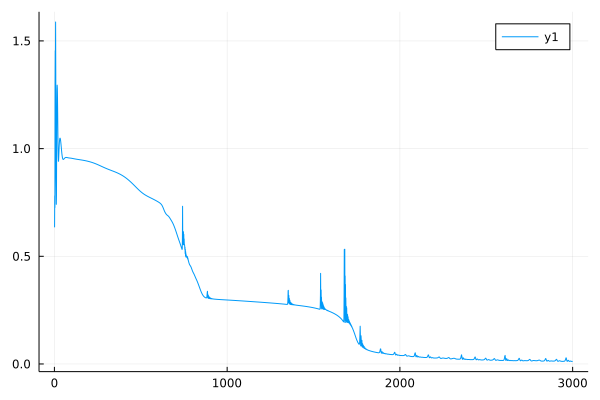

In [24]:
plot(sol.trace)

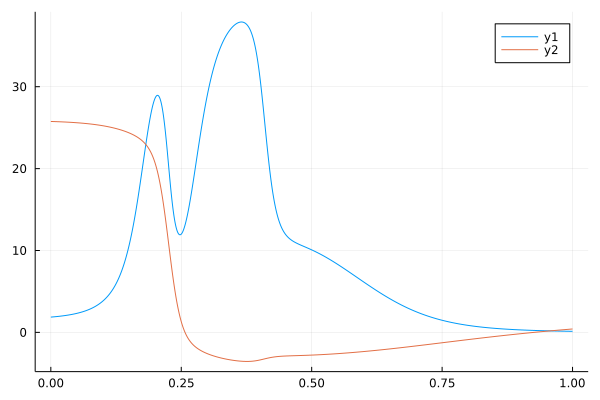

In [25]:
Ω(t) = sigmoid(ann([t], sol.params)[1])
Δ(t) = ann([t], sol.params)[2]

ts = t0:0.001:t1
f = plot(ts, Ω.(ts))
plot!(f, ts, Δ.(ts))